In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

import os
from astropy.table import Table
v4_prerelease_dirname = "/Users/aphearin/Dropbox/protoDC2/v4_prerelease"
v4_prerelease_fname = os.path.join(
    v4_prerelease_dirname, "v4_prerelease_no_interpolation.hdf5")
v4 = Table.read(v4_prerelease_fname, path='data')
print(v4.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['redshift', 'mstar', 'hostHaloMass', 'isCentral', 'mag_g', 'mag_r', 'mag_i', 'mag_g_obs', 'mag_r_obs', 'mag_i_obs', 'Lum_g', 'Lum_r', 'Lum_i', 'disk_mag_r', 'bulge_mag_r', 'lum_tot_r', 'bulge_rhalf_arcsec', 'disk_rhalf_arcsec', 'bt', 'ang_diam_dist_Mpc', 'bulge_rhalf_kpc_phys', 'disk_rhalf_kpc_phys']


Reassign r-band

In [3]:
from cosmodc2.sdss_colors import magr_monte_carlo

def remap_mag_r_obs(mag_r_obs_old, mag_r_abs_old, mag_r_abs_new):
    dmag_r = mag_r_obs_old - mag_r_abs_old
    mag_r_obs_new = dmag_r + mag_r_abs_new
    return mag_r_obs_new

# def remap_mag_i_obs(mag_r_abs_old, mag_i_abs_old, mag_i_obs_old, mag_r_abs_new):
#     ri_abs_old = mag_r_abs_old - mag_i_abs_old
#     mag_i_abs_new = ri_abs_old - mag_r_abs_new
#     dmag_i = mag_i_obs_old - mag_i_abs_old
#     mag_i_obs_new = dmag_i + mag_i_abs_new
#     return mag_i_abs_new, mag_i_obs_new

v4['mag_r_new'] = magr_monte_carlo(v4['mstar'], v4['redshift'],
                        boost_table=[0, -0.2, -0.5, -1.])
v4['mag_r_obs_new'] = remap_mag_r_obs(v4['mag_r_obs'], v4['mag_r'], v4['mag_r_new'])

v4['mag_r_new2'] = magr_monte_carlo(v4['mstar'], v4['redshift'],
                        boost_table=[0, -0.2, -0.5, -1.5])
v4['mag_r_obs_new2'] = remap_mag_r_obs(v4['mag_r_obs'], v4['mag_r'], v4['mag_r_new2'])


Reassign color

In [4]:
from cosmodc2.sdss_colors import gr_ri_monte_carlo

sfr_percentile_mock = np.random.rand(len(v4))

gr, ri, is_quiescent_ri, is_quiescent_gr = gr_ri_monte_carlo(
    v4['mag_r_new'], sfr_percentile_mock, v4['redshift'])

v4['ri_new'] = ri
v4['gr_new'] = gr

v4['mag_g_abs_new'] = v4['mag_r_new'] + v4['gr_new']
v4['mag_i_abs_new'] = v4['mag_r_new'] - v4['ri_new']

dmag_i = v4['mag_i_obs'] - v4['mag_i']
v4['mag_i_obs_new'] = dmag_i + v4['mag_i_abs_new']

print(v4.keys())

['redshift', 'mstar', 'hostHaloMass', 'isCentral', 'mag_g', 'mag_r', 'mag_i', 'mag_g_obs', 'mag_r_obs', 'mag_i_obs', 'Lum_g', 'Lum_r', 'Lum_i', 'disk_mag_r', 'bulge_mag_r', 'lum_tot_r', 'bulge_rhalf_arcsec', 'disk_rhalf_arcsec', 'bt', 'ang_diam_dist_Mpc', 'bulge_rhalf_kpc_phys', 'disk_rhalf_kpc_phys', 'mag_r_new', 'mag_r_obs_new', 'mag_r_new2', 'mag_r_obs_new2', 'ri_new', 'gr_new', 'mag_g_abs_new', 'mag_i_abs_new', 'mag_i_obs_new']


In [5]:
gr, ri, is_quiescent_ri, is_quiescent_gr = gr_ri_monte_carlo(
    v4['mag_r_new2'], sfr_percentile_mock, v4['redshift'])

v4['ri_new2'] = ri
v4['gr_new2'] = gr

v4['mag_g_abs_new2'] = v4['mag_r_new2'] + v4['gr_new2']
v4['mag_i_abs_new2'] = v4['mag_r_new2'] - v4['ri_new2']

dmag_i = v4['mag_i_obs'] - v4['mag_i']
v4['mag_i_obs_new2'] = dmag_i + v4['mag_i_abs_new2']


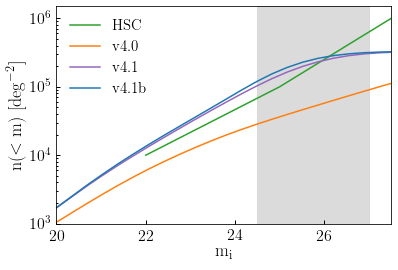

In [7]:
def dndmag(mag_i_apparent, mag_i_bins, sky_area):
    magmasks = list((mag_i_apparent < m) for m in mag_i_bins)
    counts = np.array([np.count_nonzero(mask) for mask in magmasks])
    return counts/sky_area


magarr = np.linspace(20, 30, 30)
magmasks = list((v4['mag_i_obs'] < m) for m in magarr)
counts = np.array([np.count_nonzero(mask) for mask in magmasks])
magmasks_new = list((v4['mag_i_obs_new'] < m) for m in magarr)
counts_new = np.array([np.count_nonzero(mask) for mask in magmasks_new])
magmasks_new2 = list((v4['mag_i_obs_new2'] < m) for m in magarr)
counts_new2 = np.array([np.count_nonzero(mask) for mask in magmasks_new2])

sky_area = 25.
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
x1 = np.zeros(100) + 24.5
x2 = np.zeros(100) + 27
y = np.logspace(1, 10, 100)

__=ax.fill_betweenx(y, x1, x2, alpha=0.8, color='lightgray')

hsc_ordinates = [1e4, 1e5, 1e6]
hsc_abscissa = [22, 25, 27.5]
__=ax.plot(hsc_abscissa, hsc_ordinates, label=r'${\rm HSC}$', color=mgreen)

__=ax.plot(magarr, counts/sky_area, label=r'${\rm v4.0}$', color=morange)
__=ax.plot(magarr, counts_new/sky_area, label=r'${\rm v4.1}$', color=mpurple)
__=ax.plot(magarr, counts_new2/sky_area, label=r'${\rm v4.1b}$', color=mblue)


xlabel = ax.set_xlabel(r'${\rm m_{i}}$')
ylabel = ax.set_ylabel(r'${\rm n(<m)\ [deg^{-2}]}$')
legend = ax.legend()
ylim = ax.set_ylim(1e3, 1.5e6)
xlim = ax.set_xlim(20, 27.5)

# # figname = 'hsc_dndmag_pdc2_v4.png'
# # fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

# DEEP2 $dn/dz$

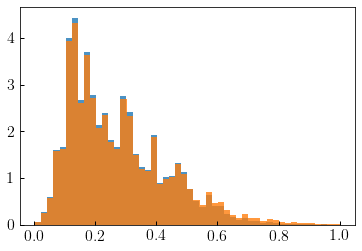

In [13]:
fig, ax = plt.subplots(1, 1)

# __=ax.hist(v4['redshift'][v4['mag_r_obs'] < 22], normed=True, bins=50)
__=ax.hist(v4['redshift'][v4['mag_r_obs_new'] < 22], normed=True, bins=50, alpha=0.8)
__=ax.hist(v4['redshift'][v4['mag_r_obs_new2'] < 22], normed=True, bins=50, alpha=0.8)